In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Fri Jul 10 09:08:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   33C    P8    23W / 250W |   6153MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   33C    P0    33W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
import mlflow

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

'''
HELPER FUNCTIONS
'''
# From model/collectdata.py
from model.collectdata_mdsA import collect_data

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu, Results

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below

from model.models_mds_07July2020 import SimpleCNN5Layer_Ca as Model
from model.models_mds_07July2020 import SimpleCNN5Layer_Ca_B as Model_B
from model.models_mds_07July2020 import All_CNN6Layer_A as ModelA
from model.models_mds_07July2020 import All_CNN6Layer_B as ModelB
from model.models_mds_07July2020 import All_CNN6Layer_C as ModelC
from model.models_mds_07July2020 import All_CNN6Layer_D as ModelD
from model.models_mds_07July2020 import All_CNN6Layer_E as ModelE

# From model/utilities.py
from model.utilities import load_full_state, count_parameters, Params

from model.plots import dual_train_plots, replace_in_ax

## adds image of model architecture
import hiddenlayer as HL

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [4]:
device = select_gpu(2)

1 available GPUs (initially using device 0):
  0 TITAN V


### Set up local parameters

In [5]:
# params order - batch size, epochs, lr, epoch_start (which is usually set to 0)
args = Params(128, 100, 1e-3, 19)

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [6]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('/share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5',
                             '/share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5',
#                             '/share/lazy/sokoloff/ML-data_AA/Oct03_40K_train.h5',
                             '/share/lazy/will/ML_mdsA/June30_2020_80k_1.h5',
                             '/share/lazy/will/ML_mdsA/June30_2020_80k_3.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_4.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_5.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_6.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_7.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_8.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_9.h5',
                            #'/share/lazy/sokoloff/ML-data_AA/Oct03_80K2_train.h5',
                             batch_size=args.batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                            device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=False,
                            load_xy=False)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=args.batch_size,
                          slice=slice(256 * 39),
                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=False,
                          load_xy=False)

Loading data...
Loaded /share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5 in 10.98 s
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5 in 10.37 s
Loaded /share/lazy/will/ML_mdsA/June30_2020_80k_1.h5 in 10.37 s
Loaded /share/lazy/will/ML_mdsA/June30_2020_80k_3.h5 in 10.33 s
Constructing 320000 event dataset took 4.717 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5 in 2.571 s
Constructing 9984 event dataset took 0.06754 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [7]:
model = Model_B()

##summary(model, input_size=(4, 4000))
##print(model.parameters)

mlflow.tracking.set_tracking_uri('file:/share/lazy/pv-finder_model_repo')
mlflow.set_experiment('ALLCNN')

Traceback (most recent call last):
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/share/lazy/pv-finder_model_repo/ML/meta.yaml' does not exist.


In [8]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


In [9]:
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

##  use the first five layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113
##   ML -> /share/lazy/sokoloff/ML

#path = 'run_stats.pyt'
#load_full_state(model, optimizer, path)
# For other pretrained models, go to MLFlow and find the path for "run_stats.pyt"
pretrained_dict = '/share/lazy/pv-finder_model_repo/7/fb1060b37aeb4d2f96fd22865a5a6e5d/artifacts/run_stats.pyt'
load_full_state(model, optimizer, pretrained_dict)

we also froze 0 weights
Of the 12 parameter layers to update in the current model, 12 were loaded
we also froze 0 weights
Of the 12 parameter layers to update in the current model, 12 were loaded


In [10]:
model.to(device)

SimpleCNN5Layer_Ca_B(
  (conv1): Conv1d(1, 16, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(16, 9, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(9, 9, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(9, 9, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(9, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.35, inplace=False)
  (fc1): Linear(in_features=4000, out_features=4000, bias=True)
)

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


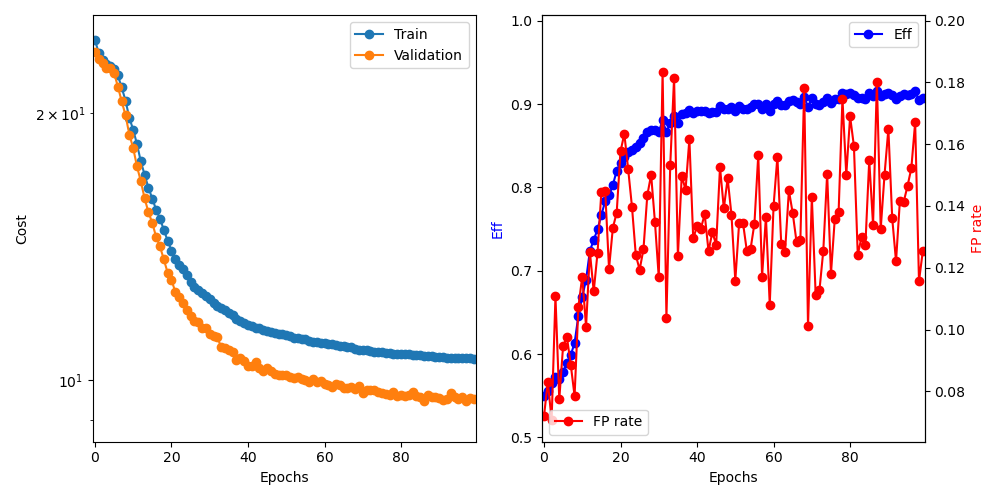

In [11]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

In [12]:
print('for model: ', model)   
run_name = 'SimpleCNN5Layer_Ca B'
# Create an mlflow run
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters of the model
    for key, value in vars(args).items():
        print(key, value)
        mlflow.log_param(key, value)
    
    # Log parameter count in the model
    mlflow.log_param('Parameters', count_parameters(model))
    
    # Begin run
    for result in trainNet(model, optimizer, loss,
                            train_loader, val_loader,
                            args.epochs+args.epoch_start, epoch_start=args.epoch_start,
                            notebook=True, device=device):

        result = result._asdict()
        results = results.append(pd.Series(result), ignore_index=True)
        xs = results.index

        # Update the plot above
        lines['train'].set_data(results.index, results.cost)
        lines['val'].set_data(results.index, results.val)

        #filter first cost epoch (can be really large)
        max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
        min_cost = min(min(results.cost), min(results.val))
    
        # The plot limits need updating too
        ax.set_ylim(min_cost*.9, max_cost*1.1)  
        ax.set_xlim(-.5, len(results.cost) - .5)
    
        replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
        replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))            
            
        # Redraw the figure
        fig.canvas.draw()
            
        ## MLFLOW ##
        # Log metrics
        mlflow.log_metric('Efficiency', result['eff_val'].eff_rate, result['epoch'])
        mlflow.log_metric('False Positive Rate',  result['eff_val'].fp_rate, result['epoch'])
        mlflow.log_metric('Validation Loss',  result['val'], result['epoch'])
        mlflow.log_metric('Training Loss',  result['cost'], result['epoch'])
            
        # Log tags
#        mlflow.set_tag('Optimizer', 'Adam')
#        mlflow.set_tag('Kernel size', 'Mixed')
#        mlflow.set_tag('Skip connections', '4')
#        mlflow.set_tag('Activation', 'Softplus')
#        mlflow.set_tag('Mid Activation', 'Relu')
        mlflow.set_tag('Extra Data', 'False')

        # Save model state dictionary, optimizer state dictionary, and epoch number
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':args.epochs+result['epoch']
            }, 'run_stats.pyt')
        # Save the run stats into mlflow
        mlflow.log_artifact('run_stats.pyt')
        
    dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
    plt.tight_layout()
    # save plot
    fig.savefig('plot.png')  
    mlflow.log_artifact('plot.png')

for model:  SimpleCNN5Layer_Ca_B(
  (conv1): Conv1d(1, 16, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(16, 9, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(9, 9, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(9, 9, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(9, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.35, inplace=False)
  (fc1): Linear(in_features=4000, out_features=4000, bias=True)
)
epoch_start 19
batch_size 128
epochs 100
lr 0.001
Number of batches: train = 2500, val = 78


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:95: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 19: train=24.1789, val=23.4292, took 61.684 s
  Validation Found 29960 of 54504, added 718 (eff 54.97%) (0.0719 FP/event)


Epoch 20: train=23.3601, val=23.02, took 60.851 s
  Validation Found 30304 of 54504, added 830 (eff 55.60%) (0.0831 FP/event)


Epoch 21: train=22.9558, val=22.7572, took 61.225 s
  Validation Found 30839 of 54504, added 707 (eff 56.58%) (0.0708 FP/event)


Epoch 22: train=22.7112, val=22.4862, took 62.351 s
  Validation Found 31185 of 54504, added 1106 (eff 57.22%) (0.111 FP/event)


Epoch 23: train=22.5722, val=22.4763, took 60.568 s
  Validation Found 31070 of 54504, added 773 (eff 57.00%) (0.0774 FP/event)


Epoch 24: train=22.4086, val=22.1817, took 60.978 s
  Validation Found 31547 of 54504, added 946 (eff 57.88%) (0.0947 FP/event)


Epoch 25: train=22.0386, val=21.4154, took 61.222 s
  Validation Found 32112 of 54504, added 974 (eff 58.92%) (0.0975 FP/event)


Epoch 26: train=21.3637, val=20.6087, took 60.795 s
  Validation Found 32639 of 54504, added 885 (eff 59.88%) (0.0886 FP/event)


Epoch 27: train=20.6474, val=19.876, took 60.696 s
  Validation Found 33427 of 54504, added 784 (eff 61.33%) (0.0785 FP/event)


Epoch 28: train=19.7386, val=18.9055, took 61.173 s
  Validation Found 35224 of 54504, added 1072 (eff 64.63%) (0.107 FP/event)


Epoch 29: train=19.1459, val=18.2553, took 61.869 s
  Validation Found 36440 of 54504, added 1170 (eff 66.86%) (0.117 FP/event)


Epoch 30: train=18.438, val=17.4001, took 61.207 s
  Validation Found 37567 of 54504, added 1008 (eff 68.93%) (0.101 FP/event)


Epoch 31: train=17.6258, val=16.7438, took 61.794 s
  Validation Found 39449 of 54504, added 1249 (eff 72.38%) (0.125 FP/event)


Epoch 32: train=17.0275, val=16.0117, took 59.951 s
  Validation Found 40171 of 54504, added 1122 (eff 73.70%) (0.112 FP/event)


Epoch 33: train=16.4587, val=15.4425, took 60.875 s
  Validation Found 40855 of 54504, added 1247 (eff 74.96%) (0.125 FP/event)


Epoch 34: train=16.0049, val=15.0292, took 59.886 s
  Validation Found 41804 of 54504, added 1444 (eff 76.70%) (0.145 FP/event)


Epoch 35: train=15.5527, val=14.4876, took 60.953 s
  Validation Found 42710 of 54504, added 1446 (eff 78.36%) (0.145 FP/event)


Epoch 36: train=15.1961, val=14.1407, took 60.348 s
  Validation Found 43088 of 54504, added 1195 (eff 79.05%) (0.12 FP/event)


Epoch 37: train=14.7629, val=13.6731, took 60.357 s
  Validation Found 43755 of 54504, added 1327 (eff 80.28%) (0.133 FP/event)


Epoch 38: train=14.3505, val=13.2065, took 60.455 s
  Validation Found 44701 of 54504, added 1376 (eff 82.01%) (0.138 FP/event)


Epoch 39: train=13.9877, val=12.9582, took 60.104 s
  Validation Found 45192 of 54504, added 1574 (eff 82.92%) (0.158 FP/event)


Epoch 40: train=13.6811, val=12.5725, took 60.05 s
  Validation Found 45624 of 54504, added 1631 (eff 83.71%) (0.163 FP/event)


Epoch 41: train=13.4666, val=12.3812, took 60.692 s
  Validation Found 45922 of 54504, added 1517 (eff 84.25%) (0.152 FP/event)


Epoch 42: train=13.3183, val=12.1921, took 60.054 s
  Validation Found 46042 of 54504, added 1395 (eff 84.47%) (0.14 FP/event)


Epoch 43: train=13.1093, val=11.9773, took 60.026 s
  Validation Found 46254 of 54504, added 1239 (eff 84.86%) (0.124 FP/event)


Epoch 44: train=12.9062, val=11.7943, took 60.38 s
  Validation Found 46506 of 54504, added 1192 (eff 85.33%) (0.119 FP/event)


Epoch 45: train=12.7387, val=11.6338, took 60.217 s
  Validation Found 46818 of 54504, added 1258 (eff 85.90%) (0.126 FP/event)


Epoch 46: train=12.6141, val=11.621, took 59.765 s
  Validation Found 47257 of 54504, added 1432 (eff 86.70%) (0.143 FP/event)


Epoch 47: train=12.5254, val=11.4313, took 59.976 s
  Validation Found 47373 of 54504, added 1499 (eff 86.92%) (0.15 FP/event)


Epoch 48: train=12.4353, val=11.4249, took 59.748 s
  Validation Found 47349 of 54504, added 1346 (eff 86.87%) (0.135 FP/event)


Epoch 49: train=12.3376, val=11.2473, took 59.931 s
  Validation Found 47253 of 54504, added 1167 (eff 86.70%) (0.117 FP/event)


Epoch 50: train=12.213, val=11.1956, took 59.841 s
  Validation Found 47986 of 54504, added 1831 (eff 88.04%) (0.183 FP/event)


Epoch 51: train=12.1112, val=11.1604, took 60.124 s
  Validation Found 47226 of 54504, added 1037 (eff 86.65%) (0.104 FP/event)


Epoch 52: train=12.0385, val=10.8836, took 60.035 s
  Validation Found 47828 of 54504, added 1530 (eff 87.75%) (0.153 FP/event)


Epoch 53: train=11.9881, val=10.8598, took 59.815 s
  Validation Found 48304 of 54504, added 1812 (eff 88.62%) (0.181 FP/event)


Epoch 54: train=11.8896, val=10.815, took 59.698 s
  Validation Found 47825 of 54504, added 1236 (eff 87.75%) (0.124 FP/event)


Epoch 55: train=11.8199, val=10.7331, took 59.754 s
  Validation Found 48428 of 54504, added 1496 (eff 88.85%) (0.15 FP/event)


Epoch 56: train=11.7109, val=10.5151, took 60.018 s
  Validation Found 48494 of 54504, added 1450 (eff 88.97%) (0.145 FP/event)


Epoch 57: train=11.6334, val=10.5701, took 60.066 s
  Validation Found 48677 of 54504, added 1614 (eff 89.31%) (0.162 FP/event)


Epoch 58: train=11.5865, val=10.4943, took 59.835 s
  Validation Found 48508 of 54504, added 1293 (eff 89.00%) (0.129 FP/event)


Epoch 59: train=11.5383, val=10.3521, took 59.665 s
  Validation Found 48619 of 54504, added 1332 (eff 89.20%) (0.133 FP/event)


Epoch 60: train=11.4837, val=10.3739, took 59.853 s
  Validation Found 48579 of 54504, added 1325 (eff 89.13%) (0.133 FP/event)


Epoch 61: train=11.4515, val=10.463, took 60.064 s
  Validation Found 48625 of 54504, added 1371 (eff 89.21%) (0.137 FP/event)


Epoch 62: train=11.4287, val=10.3123, took 59.764 s
  Validation Found 48501 of 54504, added 1252 (eff 88.99%) (0.125 FP/event)


Epoch 63: train=11.3825, val=10.2403, took 60.514 s
  Validation Found 48528 of 54504, added 1313 (eff 89.04%) (0.131 FP/event)


Epoch 64: train=11.3616, val=10.3173, took 59.921 s
  Validation Found 48524 of 54504, added 1273 (eff 89.03%) (0.127 FP/event)


Epoch 65: train=11.3285, val=10.2213, took 60.113 s
  Validation Found 48902 of 54504, added 1523 (eff 89.72%) (0.153 FP/event)


Epoch 66: train=11.2943, val=10.1572, took 59.68 s
  Validation Found 48737 of 54504, added 1390 (eff 89.42%) (0.139 FP/event)


Epoch 67: train=11.2713, val=10.1335, took 60.109 s
  Validation Found 48708 of 54504, added 1487 (eff 89.37%) (0.149 FP/event)


Epoch 68: train=11.2512, val=10.1113, took 59.768 s
  Validation Found 48896 of 54504, added 1369 (eff 89.71%) (0.137 FP/event)


Epoch 69: train=11.2356, val=10.1341, took 59.738 s
  Validation Found 48626 of 54504, added 1157 (eff 89.22%) (0.116 FP/event)


Epoch 70: train=11.1937, val=10.0643, took 59.703 s
  Validation Found 48926 of 54504, added 1343 (eff 89.77%) (0.135 FP/event)


Epoch 71: train=11.1521, val=10.0532, took 59.66 s
  Validation Found 48770 of 54504, added 1344 (eff 89.48%) (0.135 FP/event)


Epoch 72: train=11.135, val=10.0743, took 59.707 s
  Validation Found 48763 of 54504, added 1254 (eff 89.47%) (0.126 FP/event)


Epoch 73: train=11.1217, val=10.032, took 59.913 s
  Validation Found 48851 of 54504, added 1260 (eff 89.63%) (0.126 FP/event)


Epoch 74: train=11.1027, val=9.98508, took 59.751 s
  Validation Found 49053 of 54504, added 1341 (eff 90.00%) (0.134 FP/event)


Epoch 75: train=11.0611, val=9.95177, took 59.729 s
  Validation Found 49081 of 54504, added 1563 (eff 90.05%) (0.157 FP/event)


Epoch 76: train=11.0377, val=10.0142, took 59.628 s
  Validation Found 48728 of 54504, added 1170 (eff 89.40%) (0.117 FP/event)


Epoch 77: train=11.0252, val=9.93583, took 59.78 s
  Validation Found 49034 of 54504, added 1363 (eff 89.96%) (0.137 FP/event)


Epoch 78: train=11.0137, val=9.96858, took 59.719 s
  Validation Found 48582 of 54504, added 1079 (eff 89.13%) (0.108 FP/event)


Epoch 79: train=10.9939, val=9.88785, took 59.768 s
  Validation Found 49066 of 54504, added 1398 (eff 90.02%) (0.14 FP/event)


Epoch 80: train=10.9761, val=9.86448, took 59.68 s
  Validation Found 49242 of 54504, added 1557 (eff 90.35%) (0.156 FP/event)


Epoch 81: train=10.9626, val=9.80399, took 59.903 s
  Validation Found 49005 of 54504, added 1275 (eff 89.91%) (0.128 FP/event)


Epoch 82: train=10.946, val=9.89148, took 59.912 s
  Validation Found 49019 of 54504, added 1250 (eff 89.94%) (0.125 FP/event)


Epoch 83: train=10.9207, val=9.85919, took 59.719 s
  Validation Found 49249 of 54504, added 1448 (eff 90.36%) (0.145 FP/event)


Epoch 84: train=10.9045, val=9.77638, took 59.66 s
  Validation Found 49303 of 54504, added 1375 (eff 90.46%) (0.138 FP/event)


Epoch 85: train=10.8939, val=9.80025, took 60.304 s
  Validation Found 49220 of 54504, added 1282 (eff 90.31%) (0.128 FP/event)


Epoch 86: train=10.8786, val=9.8174, took 59.877 s
  Validation Found 49054 of 54504, added 1287 (eff 90.00%) (0.129 FP/event)


Epoch 87: train=10.8395, val=9.76774, took 59.657 s
  Validation Found 49509 of 54504, added 1778 (eff 90.84%) (0.178 FP/event)


Epoch 88: train=10.814, val=9.84679, took 60.621 s
  Validation Found 48869 of 54504, added 1009 (eff 89.66%) (0.101 FP/event)


Epoch 89: train=10.8011, val=9.65677, took 61.614 s
  Validation Found 49432 of 54504, added 1427 (eff 90.69%) (0.143 FP/event)


Epoch 90: train=10.7925, val=9.74386, took 60.381 s
  Validation Found 49044 of 54504, added 1111 (eff 89.98%) (0.111 FP/event)


Epoch 91: train=10.7739, val=9.72491, took 59.772 s
  Validation Found 49007 of 54504, added 1127 (eff 89.91%) (0.113 FP/event)


Epoch 92: train=10.7586, val=9.72853, took 59.909 s
  Validation Found 49166 of 54504, added 1254 (eff 90.21%) (0.126 FP/event)


Epoch 93: train=10.7596, val=9.69552, took 60.134 s
  Validation Found 49476 of 54504, added 1502 (eff 90.77%) (0.15 FP/event)


Epoch 94: train=10.7422, val=9.66534, took 59.757 s
  Validation Found 49115 of 54504, added 1179 (eff 90.11%) (0.118 FP/event)


Epoch 95: train=10.7291, val=9.63656, took 59.595 s
  Validation Found 49389 of 54504, added 1357 (eff 90.62%) (0.136 FP/event)


Epoch 96: train=10.7059, val=9.60872, took 59.876 s
  Validation Found 49410 of 54504, added 1379 (eff 90.65%) (0.138 FP/event)


Epoch 97: train=10.7041, val=9.68943, took 59.667 s
  Validation Found 49770 of 54504, added 1745 (eff 91.31%) (0.175 FP/event)


Epoch 98: train=10.6982, val=9.57881, took 59.547 s
  Validation Found 49696 of 54504, added 1498 (eff 91.18%) (0.15 FP/event)


Epoch 99: train=10.6922, val=9.61595, took 59.808 s
  Validation Found 49773 of 54504, added 1687 (eff 91.32%) (0.169 FP/event)


Epoch 100: train=10.6834, val=9.59671, took 59.694 s
  Validation Found 49630 of 54504, added 1591 (eff 91.06%) (0.159 FP/event)


Epoch 101: train=10.6799, val=9.60601, took 59.93 s
  Validation Found 49438 of 54504, added 1240 (eff 90.71%) (0.124 FP/event)


Epoch 102: train=10.6759, val=9.69029, took 59.623 s
  Validation Found 49490 of 54504, added 1298 (eff 90.80%) (0.13 FP/event)


Epoch 103: train=10.663, val=9.58306, took 60.404 s
  Validation Found 49394 of 54504, added 1273 (eff 90.62%) (0.127 FP/event)


Epoch 104: train=10.6555, val=9.55325, took 60.074 s
  Validation Found 49808 of 54504, added 1546 (eff 91.38%) (0.155 FP/event)


Epoch 105: train=10.6484, val=9.47482, took 59.806 s
  Validation Found 49616 of 54504, added 1336 (eff 91.03%) (0.134 FP/event)


Epoch 106: train=10.6394, val=9.62125, took 59.805 s
  Validation Found 49887 of 54504, added 1799 (eff 91.53%) (0.18 FP/event)


Epoch 107: train=10.63, val=9.55197, took 60.394 s
  Validation Found 49559 of 54504, added 1324 (eff 90.93%) (0.133 FP/event)


Epoch 108: train=10.6189, val=9.55435, took 59.827 s
  Validation Found 49703 of 54504, added 1499 (eff 91.19%) (0.15 FP/event)


Epoch 109: train=10.6155, val=9.54214, took 59.939 s
  Validation Found 49814 of 54504, added 1647 (eff 91.40%) (0.165 FP/event)


Epoch 110: train=10.6001, val=9.47997, took 60.342 s
  Validation Found 49632 of 54504, added 1359 (eff 91.06%) (0.136 FP/event)


Epoch 111: train=10.5938, val=9.51591, took 59.783 s
  Validation Found 49396 of 54504, added 1219 (eff 90.63%) (0.122 FP/event)


Epoch 112: train=10.5869, val=9.6718, took 59.65 s
  Validation Found 49613 of 54504, added 1413 (eff 91.03%) (0.142 FP/event)


Epoch 113: train=10.5881, val=9.55108, took 59.621 s
  Validation Found 49701 of 54504, added 1411 (eff 91.19%) (0.141 FP/event)


Epoch 114: train=10.5786, val=9.5113, took 60.03 s
  Validation Found 49664 of 54504, added 1462 (eff 91.12%) (0.146 FP/event)


Epoch 115: train=10.5714, val=9.57254, took 59.762 s
  Validation Found 49708 of 54504, added 1520 (eff 91.20%) (0.152 FP/event)


Epoch 116: train=10.5709, val=9.45898, took 59.853 s
  Validation Found 49884 of 54504, added 1668 (eff 91.52%) (0.167 FP/event)


Epoch 117: train=10.5673, val=9.53609, took 59.734 s
  Validation Found 49305 of 54504, added 1155 (eff 90.46%) (0.116 FP/event)


Epoch 118: train=10.5608, val=9.52099, took 59.543 s
  Validation Found 49466 of 54504, added 1252 (eff 90.76%) (0.125 FP/event)



In [13]:
##quit()